Outlier Detection

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./datasets/Clean_Dataset.csv',index_col=0)

In [4]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 27.5+ MB


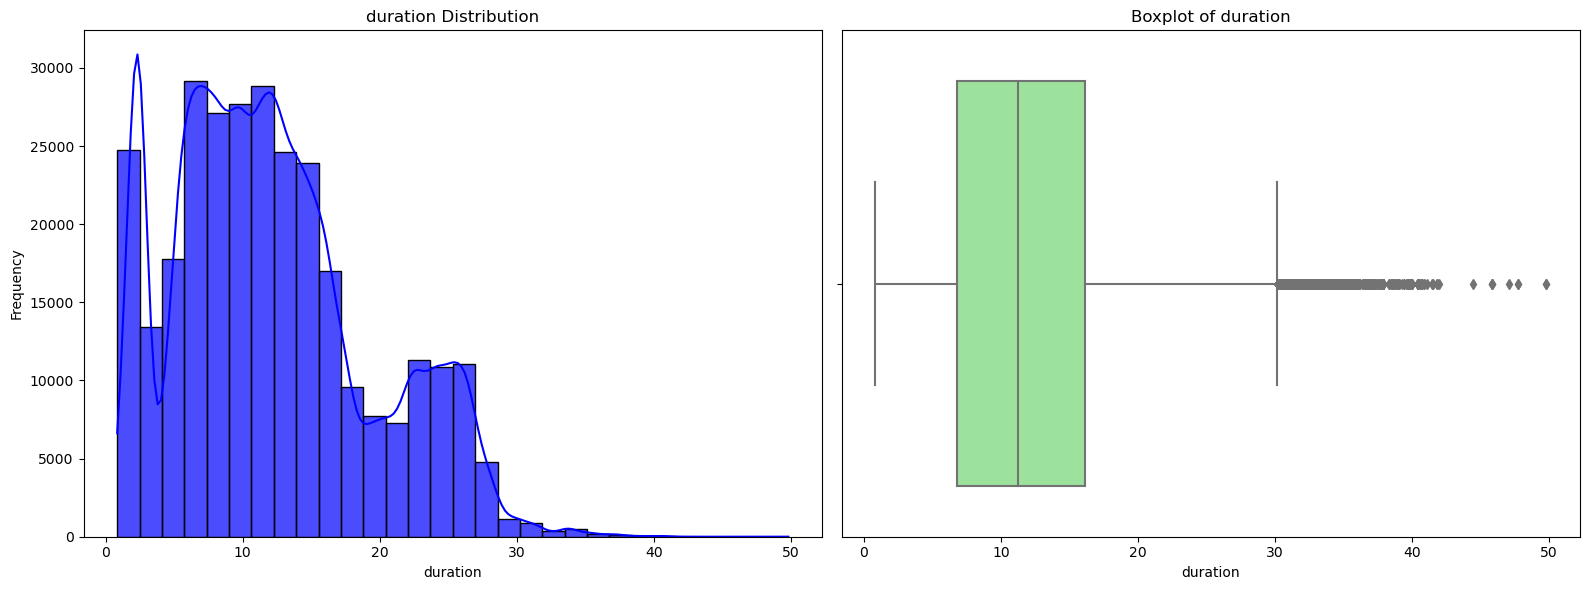

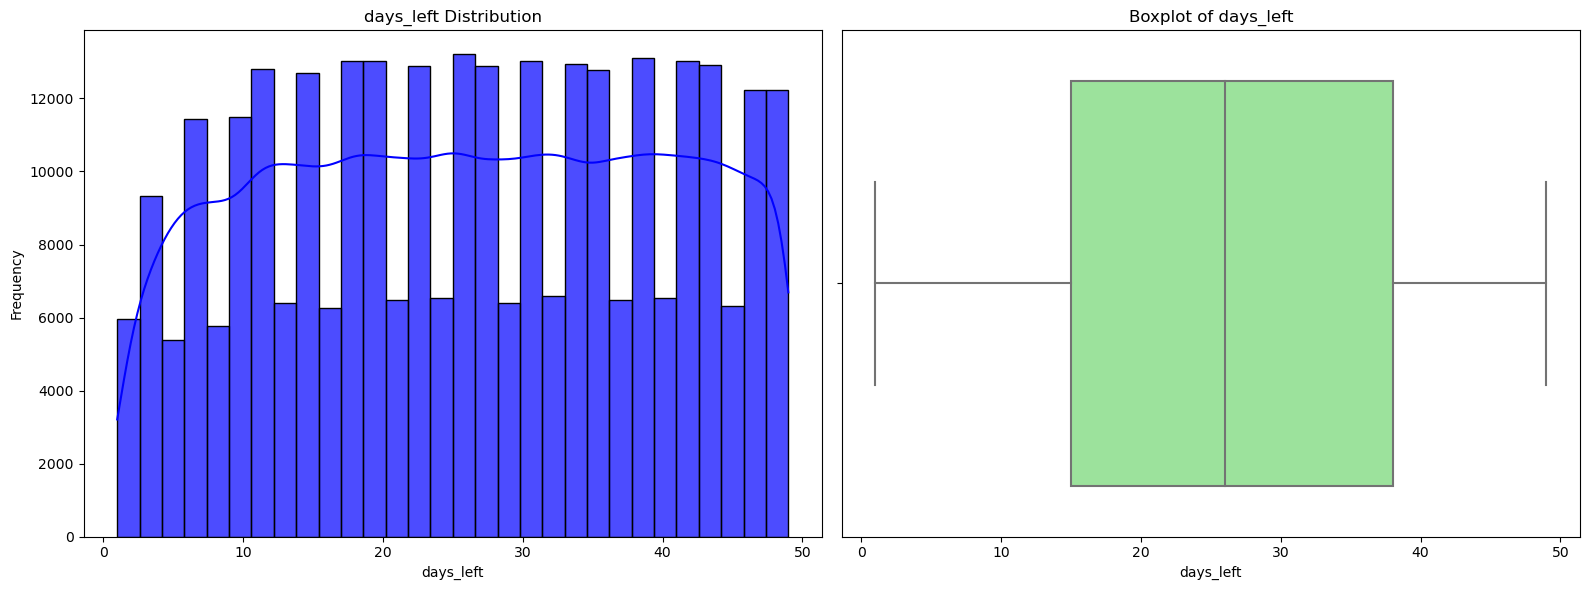

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features excluding 'price'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col != 'price']

# Plot settings
for feature in numeric_features:
    plt.figure(figsize=(16, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature], color='lightgreen')
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()


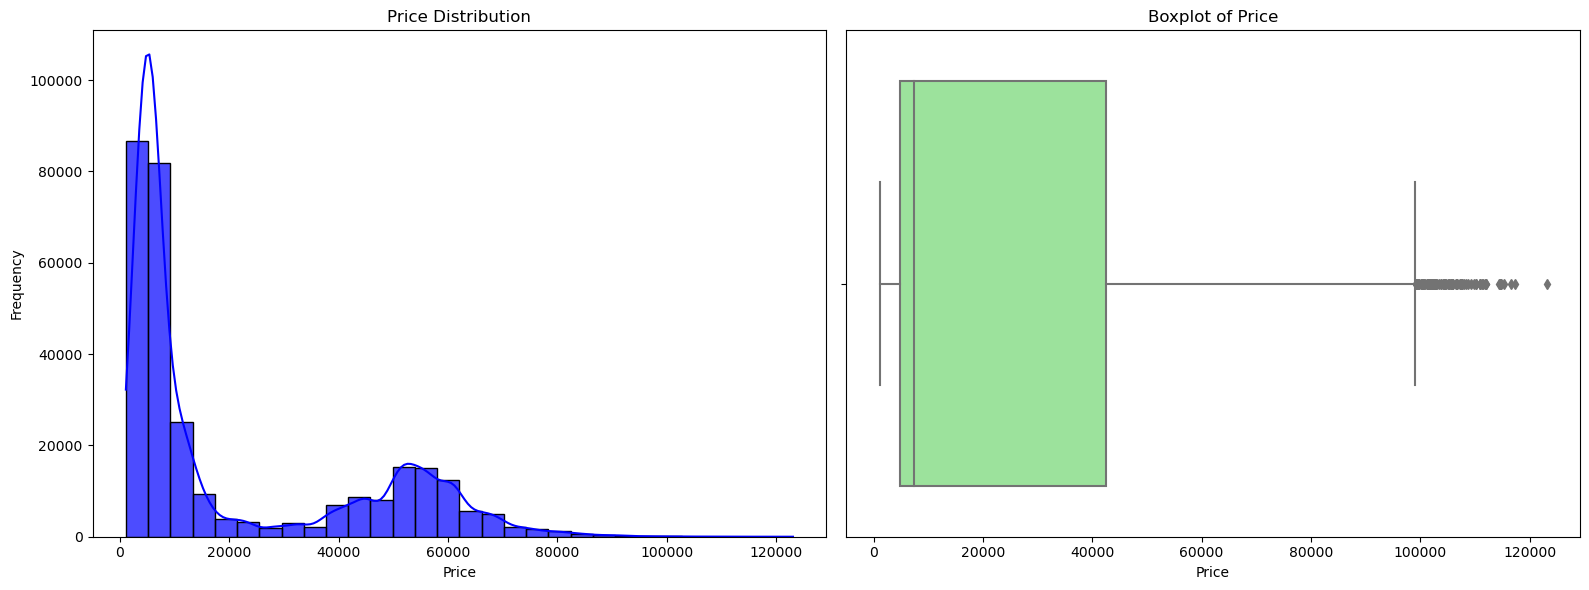

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(16, 6))

# plt.subplot(1, 2, 1)
# sns.histplot(df['price'], kde=True, bins=30, color='blue', alpha=0.7)
# plt.title('Price Distribution')
# plt.xlabel('Price')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# sns.boxplot(x=df['price'], color='lightgreen')
# plt.title('Boxplot of Price')
# plt.xlabel('Price')

# plt.tight_layout()
# plt.show()

In [ ]:
# Q1 = df['price'].quantile(0.25)
# Q3 = df['price'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
# print(f"Number of outliers: {len(outliers)}")

Number of outliers: 123


In [5]:
# Select numeric features excluding 'price'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col != 'price']
outliers_indices = set()
outliers_per_feature = {}

# Identify and collect indices of outliers for each numeric feature
for feature in numeric_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find indices of outliers for the current feature
    feature_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outliers_per_feature[feature] = feature_outliers.index.tolist()
    outliers_indices.update(feature_outliers.index)  # Add indices to the set to avoid duplicates

# Print outliers for each feature
for feature, indices in outliers_per_feature.items():
    print(f"Feature: {feature}")
    if indices:
        # print(f"Outliers indices: {indices}")
        print(f"Number of outliers: {len(indices)}")
    else:
        print("No outliers found.")
    print("-" * 40)

# Print total number of unique outliers
print(f"Total unique outlier rows: {len(outliers_indices)}")



Feature: duration
Number of outliers: 2110
----------------------------------------
Feature: days_left
No outliers found.
----------------------------------------
Total unique outlier rows: 2110


In [6]:
# Drop all outlier rows
if outliers_indices:
    df = df.drop(index=outliers_indices)
    print(f"Dropped {len(outliers_indices)} outlier rows.")
else:
    print("No outliers found.")

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

Dropped 2110 outlier rows.


In [ ]:
# outliers_idx = outliers.index.tolist()

In [ ]:
# if outliers_idx:
#     df = df.drop(outliers_idx)
#     print(f"Dropped {len(outliers_idx)} outlier rows.")
# else:
#     print("No outliers found.")
# df.reset_index(drop=True, inplace=True)

No outliers found.


In [55]:
df.shape

(298043, 11)

In [7]:
stops_mapping = {'zero': 0 , 'one': 1, 'two_or_more': 2}
df['stops'] = df['stops'].map(stops_mapping)

In [8]:
df['stops'].value_counts()

1    249573
0     36004
2     12466
Name: stops, dtype: int64

In [9]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,Economy,2.33,1,5955


In [10]:
df['airline'].value_counts()

Vistara      127040
Air_India     79601
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298043 entries, 0 to 298042
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           298043 non-null  object 
 1   flight            298043 non-null  object 
 2   source_city       298043 non-null  object 
 3   departure_time    298043 non-null  object 
 4   stops             298043 non-null  int64  
 5   arrival_time      298043 non-null  object 
 6   destination_city  298043 non-null  object 
 7   class             298043 non-null  object 
 8   duration          298043 non-null  float64
 9   days_left         298043 non-null  int64  
 10  price             298043 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 25.0+ MB


In [8]:
time_mapping = {
    'Early_Morning': 0,
    'Morning': 1,
    'Afternoon': 2,
    'Evening': 3,
    'Night': 4,
    'Late_Night': 5
}

df['arrival_time'] = df['arrival_time'].map(time_mapping)
df['departure_time'] = df['departure_time'].map(time_mapping)

In [12]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,3,0,4,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,0,0,1,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,0,0,0,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,1,0,2,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,1,0,1,Mumbai,Economy,2.33,1,5955


In [9]:
from sklearn.preprocessing import LabelEncoder

le_class = LabelEncoder()
le_fligh = LabelEncoder()

df['class'] = le_class.fit_transform(df['class'])
df['flight'] = le_fligh.fit_transform(df['flight'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298043 entries, 0 to 298042
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           298043 non-null  object 
 1   flight            298043 non-null  int32  
 2   source_city       298043 non-null  object 
 3   departure_time    298043 non-null  int64  
 4   stops             298043 non-null  int64  
 5   arrival_time      298043 non-null  int64  
 6   destination_city  298043 non-null  object 
 7   class             298043 non-null  int32  
 8   duration          298043 non-null  float64
 9   days_left         298043 non-null  int64  
 10  price             298043 non-null  int64  
dtypes: float64(1), int32(2), int64(5), object(3)
memory usage: 22.7+ MB


In [ ]:
# city_mapping = {
#     'Delhi': 0,
#     'Mumbai': 1,
#     'Bangalore': 2,
#     'Kolkata': 3,
#     'Hyderabad': 4,
#     'Chennai': 5
# }

# df['source_city'] = df['source_city'].map(city_mapping)
# df['destination_city'] = df['destination_city'].map(city_mapping)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298043 entries, 0 to 298042
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           298043 non-null  object 
 1   flight            298043 non-null  int32  
 2   source_city       298043 non-null  object 
 3   departure_time    298043 non-null  int64  
 4   stops             298043 non-null  int64  
 5   arrival_time      298043 non-null  int64  
 6   destination_city  298043 non-null  object 
 7   class             298043 non-null  int32  
 8   duration          298043 non-null  float64
 9   days_left         298043 non-null  int64  
 10  price             298043 non-null  int64  
dtypes: float64(1), int32(2), int64(5), object(3)
memory usage: 22.7+ MB


In [11]:
# **Using pandas get_dummies() for one-hot encoding**
from sklearn.preprocessing import OneHotEncoder

df_pandas_encoded = pd.get_dummies(df, columns=['airline','source_city','destination_city'], drop_first=True)
print(f"One-Hot Encoded Data using Pandas:\n{df_pandas_encoded}\n")

# **Using sklearn's OneHotEncoder**
# Define the column to encode
categorical_columns = ['airline','source_city','destination_city']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False) 

# Fit and transform the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

# Create a DataFrame with the encoded columns
one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded columns with the original DataFrame (excluding original categorical column)
df_sklearn_encoded = pd.concat([df.drop(categorical_columns, axis=1), one_hot_df], axis=1)

print(f"One-Hot Encoded Data using scikit-learn:\n{df_sklearn_encoded}\n")

One-Hot Encoded Data using Pandas:
        flight  departure_time  stops  arrival_time  class  duration  \
0         1408               3      0             4      1      2.17   
1         1387               0      0             1      1      2.33   
2         1213               0      0             0      1      2.17   
3         1559               1      0             2      1      2.25   
4         1549               1      0             1      1      2.33   
...        ...             ...    ...           ...    ...       ...   
298038    1477               1      1             3      0     10.08   
298039    1481               2      1             4      0     10.42   
298040    1486               0      1             4      0     13.83   
298041    1483               0      1             3      0     10.00   
298042    1477               1      1             3      0     10.08   

        days_left  price  airline_Air_India  airline_GO_FIRST  ...  \
0               1   5953      

In [ ]:
# df_sklearn_encoded['source_city'].unique()

In [18]:
df_sklearn_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298043 entries, 0 to 298042
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   flight                      298043 non-null  int32  
 1   departure_time              298043 non-null  int64  
 2   stops                       298043 non-null  int64  
 3   arrival_time                298043 non-null  int64  
 4   class                       298043 non-null  int32  
 5   duration                    298043 non-null  float64
 6   days_left                   298043 non-null  int64  
 7   price                       298043 non-null  int64  
 8   airline_AirAsia             298043 non-null  float64
 9   airline_Air_India           298043 non-null  float64
 10  airline_GO_FIRST            298043 non-null  float64
 11  airline_Indigo              298043 non-null  float64
 12  airline_SpiceJet            298043 non-null  float64
 13  airline_Vistar

In [16]:
df.to_csv('./datasets/final_dataset.csv', index = False)

In [18]:
# df.head()
df_sklearn_encoded = pd.read_csv('./datasets/final_dataset.csv')

In [13]:
X=df_sklearn_encoded.drop(['price'],axis=1)
y=df_sklearn_encoded['price']

##### Feature Selection

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298043 entries, 0 to 298042
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   departure_time              298043 non-null  int64  
 1   stops                       298043 non-null  int64  
 2   arrival_time                298043 non-null  int64  
 3   class                       298043 non-null  int32  
 4   duration                    298043 non-null  float64
 5   days_left                   298043 non-null  int64  
 6   airline_AirAsia             298043 non-null  float64
 7   airline_Air_India           298043 non-null  float64
 8   airline_GO_FIRST            298043 non-null  float64
 9   airline_Indigo              298043 non-null  float64
 10  airline_SpiceJet            298043 non-null  float64
 11  airline_Vistara             298043 non-null  float64
 12  source_city_Bangalore       298043 non-null  float64
 13  source_city_Ch

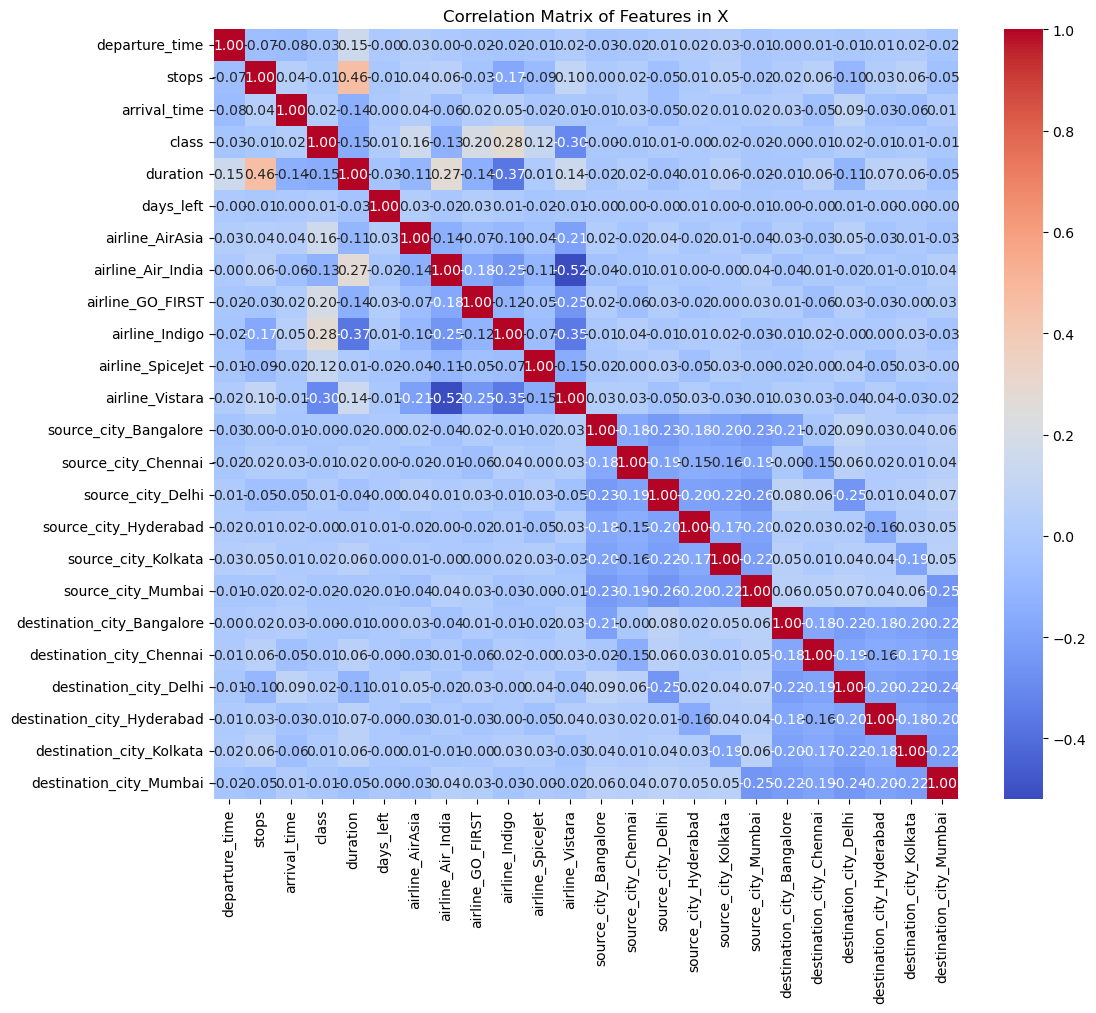

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix of Features in X")
plt.show()


In [26]:
# Check pairwise correlations
correlation_matrix = X.corr()
# print("Correlation Matrix:\n", correlation_matrix)
high_corr_pairs = correlation_matrix[(correlation_matrix > 0.9) & (correlation_matrix < 1)].stack()
print("Highly correlated variable pairs:")
print(high_corr_pairs)

# Optionally drop one of the variables from each correlated pair
# Example: X.drop(columns=['highly_correlated_column'], inplace=True)


Highly correlated variable pairs:
Series([], dtype: float64)


In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calc_vif(z):
    """
    Calculate Variance Inflation Factor (VIF) for each variable in the DataFrame.
    """
    # Ensure all data is float (VIF computations sometimes fail for mixed types)
    z = z.astype(float)

    # Compute VIF for each feature
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return vif

from sklearn.preprocessing import StandardScaler

# Standardize the DataFrame
X_standardized = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Recalculate VIF
vif_result = calc_vif(X_standardized)
print(vif_result)

                     variables           VIF
0               departure_time  1.061384e+00
1                        stops  1.369981e+00
2                 arrival_time  1.050024e+00
3                        class  1.265748e+00
4                     duration  1.731618e+00
5                    days_left  1.003319e+00
6              airline_AirAsia  2.638652e+06
7            airline_Air_India  4.118635e+05
8             airline_GO_FIRST  3.478984e+06
9               airline_Indigo  6.350384e+05
10            airline_SpiceJet  1.725622e+04
11             airline_Vistara  5.768779e+05
12       source_city_Bangalore  4.960060e+05
13         source_city_Chennai  4.818622e+05
14           source_city_Delhi  1.398111e+04
15       source_city_Hyderabad  5.839106e+05
16         source_city_Kolkata  2.437093e+05
17          source_city_Mumbai  4.952958e+05
18  destination_city_Bangalore  4.119504e+04
19    destination_city_Chennai  4.197584e+05
20      destination_city_Delhi  2.125673e+05
21  destin

Explained variance ratio:
[7.68282999e-01 2.04852057e-01 8.46963179e-03 7.29444327e-03
 1.50222578e-03 1.04388988e-03 1.00919014e-03 9.59988531e-04
 8.16522175e-04 7.09750177e-04 6.42661703e-04 6.26103250e-04
 5.90599139e-04 5.65732770e-04 5.19934145e-04 4.91673289e-04
 4.81090088e-04 4.13319716e-04 3.46526745e-04 2.45904954e-04
 1.35756243e-04 2.05996428e-31 7.46004894e-32 5.07150542e-33]


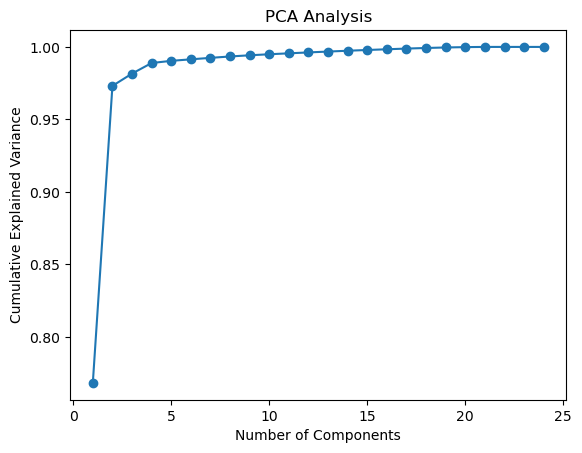

In [30]:
from sklearn.decomposition import PCA

# Fit PCA on the features
pca = PCA()
pca.fit(X)

# Examine the explained variance ratio for each component
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

# Visualize cumulative variance explained
import matplotlib.pyplot as plt
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Analysis")
plt.show()


[5.19720203e-03 2.92599305e-02 5.24829200e-03 8.80621305e-01
 2.81150132e-02 1.84526628e-02 3.84201283e-04 5.64697881e-03
 8.61013260e-05 2.93543149e-04 5.49113621e-05 4.92040382e-03
 1.09888496e-03 7.82245728e-04 4.01230509e-03 1.30437975e-03
 1.70622372e-03 2.21765302e-03 1.16714375e-03 7.48000789e-04
 3.81887224e-03 1.25238395e-03 1.79769677e-03 1.81366459e-03]


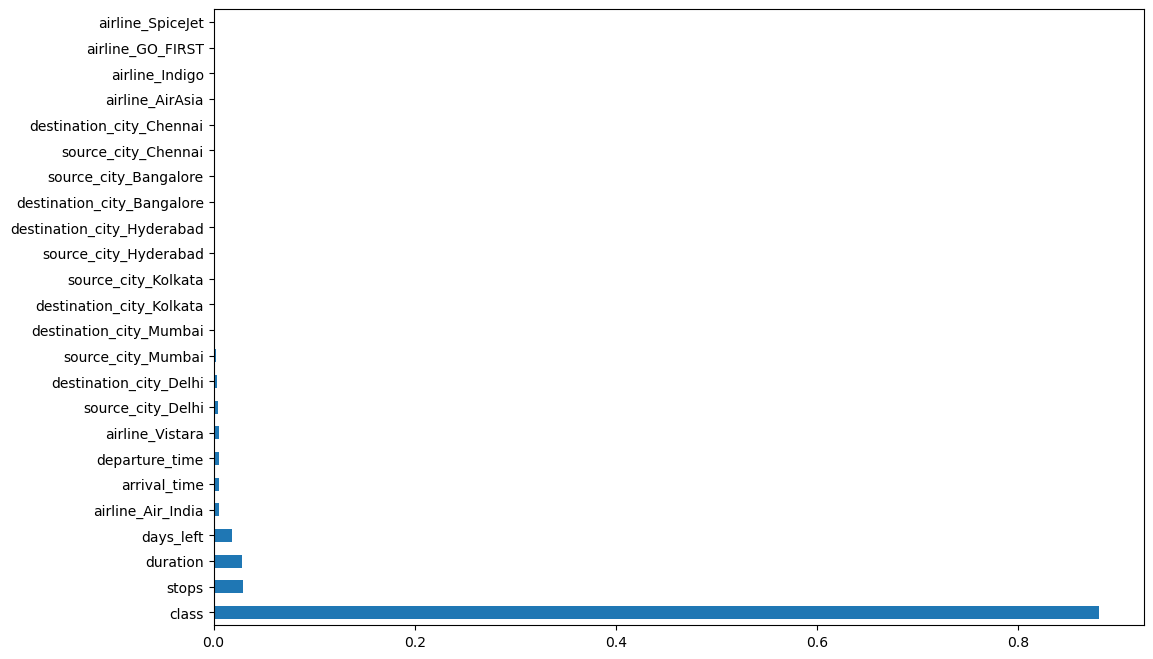

In [19]:
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)
print(selection.feature_importances_)

# Plot graph of feature importances for better visualization
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [20]:

# Checking for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(z):
    # Calculating Variable Inflation Factor (VIF)
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return(vif)

# Compute VIF on X
calc_vif(X)

c:\Users\aarzo\anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,departure_time,1.061556
1,stops,1.383171
2,arrival_time,1.050614
3,class,1.265866
4,duration,1.731674
5,days_left,1.003582
6,airline_AirAsia,inf
7,airline_Air_India,inf
8,airline_GO_FIRST,inf
9,airline_Indigo,inf


In [ ]:
# X = X.drop(['flight'],axis=1)

In [31]:
from sklearn.decomposition import PCA
import pandas as pd

# Initialize PCA with the optimal number of components (e.g., 5 or 6)
n_components = 6
pca = PCA(n_components=n_components)

# Fit PCA on the data and transform it
X_pca = pca.fit_transform(X)

# Create a DataFrame of the principal components
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Display the transformed dataset
print(X_pca_df.head())

# Optional: Variance explained by selected components
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by each component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")


         PC1        PC2       PC3       PC4       PC5       PC6
0  24.787237 -10.521277  0.869711 -1.532063  0.340710 -0.999736
1  24.790486 -10.373254 -0.458204  2.494422  0.301567 -0.929872
2  24.785997 -10.509164  0.003004  3.376963  0.307692 -0.916442
3  24.788808 -10.439613 -0.018693  1.144651 -0.497091 -0.965343
4  24.790913 -10.332312  0.428099  2.034880 -0.507156 -0.944326
Explained Variance by each component: [0.768283   0.20485206 0.00846963 0.00729444 0.00150222 0.00104291]
Total explained variance: 0.9914442569291778


In [36]:
X_pca_df.to_csv("reduced_features.csv", index=False)


In [ ]:
X = X.drop(['flight','source_city_Bangalore','destination_city_Bangalore'],axis=1)

In [17]:
# Compute VIF on X
calc_vif(X)

c:\Users\aarzo\anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,departure_time,1.061556
1,stops,1.383171
2,arrival_time,1.050614
3,class,1.265866
4,duration,1.731674
5,days_left,1.003582
6,airline_AirAsia,inf
7,airline_Air_India,inf
8,airline_GO_FIRST,inf
9,airline_Indigo,inf


In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298043 entries, 0 to 298042
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   departure_time              298043 non-null  int64  
 1   stops                       298043 non-null  int64  
 2   arrival_time                298043 non-null  int64  
 3   class                       298043 non-null  int32  
 4   duration                    298043 non-null  float64
 5   days_left                   298043 non-null  int64  
 6   airline_AirAsia             298043 non-null  float64
 7   airline_Air_India           298043 non-null  float64
 8   airline_GO_FIRST            298043 non-null  float64
 9   airline_Indigo              298043 non-null  float64
 10  airline_SpiceJet            298043 non-null  float64
 11  airline_Vistara             298043 non-null  float64
 12  source_city_Bangalore       298043 non-null  float64
 13  source_city_Ch

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_pca_df,y,test_size=0.30,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((208630, 6), (89413, 6), (208630,), (89413,))

In [39]:
from sklearn.model_selection import train_test_split
X_train2,X_test2,y_train2,y_test2=train_test_split(X,y,test_size=0.30,random_state=42)
X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape

((208630, 24), (89413, 24), (208630,), (89413,))

In [33]:
def adjusted_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

r2_scores = {}

def evaluate_metrics(X_train, X_test, y_train_pred, y_test_pred,model_name = None):
    n_train, k_train = X_train.shape
    n_test, k_test = X_test.shape

    # MSE and RMSE
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    # R2 and Adjusted R2
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    if model_name is not None:
        r2_scores[model_name] = r2_test

    adj_r2_train = adjusted_r2_score(r2_train, n_train, k_train)
    adj_r2_test = adjusted_r2_score(r2_test, n_test, k_test)

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print results
    print(f'Train MSE: {mse_train}, Test MSE: {mse_test}')
    print(f'Train RMSE: {rmse_train}, Test RMSE: {rmse_test}')
    print(f'Train R2: {r2_train}, Test R2: {r2_test}')
    print(f'Train Adjusted R2: {adj_r2_train}, Test Adjusted R2: {adj_r2_test}')
    print(f'Train MAE: {mae_train}, Test MAE: {mae_test}')

In [40]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train2, y_train2)

RandomForestRegressor(random_state=42)

In [42]:
y_pred = rf_regressor.predict(X_test2)
y_train_pred = rf_regressor.predict(X_train2)

evaluate_metrics(X_train2,X_test2,y_train_pred,y_pred,'Random Forest')

Train MSE: 1275850.0525909076, Test MSE: 7664316.638567866
Train RMSE: 1129.5353259597096, Test RMSE: 2768.450223241853
Train R2: 0.997530109650164, Test R2: 0.9851773101684422
Train Adjusted R2: 0.9975298254893414, Test Adjusted R2: 0.9851733303886513
Train MAE: 424.90132663514174, Test MAE: 1096.1823256413131


In [35]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
y_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Random Forest')

Train MSE: 1622407.8329493112, Test MSE: 9951008.210611071
Train RMSE: 1273.7377410398544, Test RMSE: 3154.5218671949433
Train R2: 0.9968592159854817, Test R2: 0.9807548780702863
Train Adjusted R2: 0.9968591256564955, Test Adjusted R2: 0.9807535865380448
Train MAE: 498.6820226427315, Test MAE: 1288.8352975149655


In [76]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [77]:
y_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Random Forest')

Train MSE: 1280769.8938874165, Test MSE: 7696213.012168651
Train RMSE: 1131.7110469936292, Test RMSE: 2774.2049333401187
Train R2: 0.997520585436471, Test R2: 0.9851156229920205
Train Adjusted R2: 0.9975203358405503, Test Adjusted R2: 0.9851121263098358
Train MAE: 426.1782790512441, Test MAE: 1098.3611953633042


In [78]:
import pickle 

In [81]:
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [82]:
save_model(rf_regressor, './checkpoint/random_forest.pkl')

OSError: [Errno 28] No space left on device

In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

In [ ]:
y_pred = lin_reg.predict(X_test)
y_train_pred = lin_reg.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Linear Regression')

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

In [ ]:
y_pred = dt_regressor.predict(X_test)
y_train_pred = dt_regressor.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Decision Tree')

In [ ]:
#Bagging Regressor
from sklearn.ensemble import BaggingRegressor
base_estimator = DecisionTreeRegressor(random_state=42)
bagging_regressor = BaggingRegressor(estimator=base_estimator, n_estimators=300, random_state=42)
bagging_regressor.fit(X_train, y_train)

y_pred = bagging_regressor.predict(X_test)
y_train_pred = bagging_regressor.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Bagging Regressor')

In [ ]:
#XGB
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)
y_train_pred = xgb_reg.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'XGBoost')


In [ ]:
#Ridge Regression
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred = ridge_reg.predict(X_test)
y_train_pred = ridge_reg.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Ridge')


In [ ]:
#Lasso Regression
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)

y_pred = lasso_reg.predict(X_test)
y_train_pred = lasso_reg.predict(X_train)

evaluate_metrics(X_train,X_test,y_train_pred,y_pred,'Lasso')


In [ ]:
# Plotting the bar chart
models = list(r2_scores.keys())
r2_values = list(r2_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='skyblue')  
plt.ylabel('R² Score')
plt.xlabel('Models')
plt.title('Comparison of R² Scores for Different Models')
plt.ylim(0, 1)
plt.xticks(rotation=45)  
plt.grid(axis='y')  

# Display the plot
plt.show()


In [ ]:
# SVM Regressor
from sklearn.svm import SVR

# Initialize the SVR model with desired hyperparameters
svm_reg = SVR(kernel='linear')

# Fit the model to the training data
svm_reg.fit(X_train, y_train)

# Make predictions
y_pred = svm_reg.predict(X_test)
y_train_pred = svm_reg.predict(X_train)

# Evaluate the model (using the same evaluation function as in your code)
evaluate_metrics(X_train, X_test, y_train_pred, y_pred, 'SVM Regressor')